# Import packages and define functions

In [121]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [122]:
# creates dictionary of variance inflation factors. 
def create_vif_list(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    return vif_dict

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y,n=1):

    linreg = LinearRegression()
    selector = RFE(linreg,n_features_to_select=n)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y,select_rank=False):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    if select_rank == True:
        return selections
    else:
        return rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict

def create_CC_df(X,minimum=0,maximum=1):

    cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
    cor_df.set_index(['pairs'], inplace = True)
    cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
    cor_df.columns = ['cc']
    cor_df.drop_duplicates(inplace=True)
    cor_df = cor_df[(cor_df.cc>minimum) & (cor_df.cc < maximum)]
    
    return cor_df

def model_strength_indicators(model):
    indicator_dict = {
    'r_squared':model.summary2().tables[0][3][0],
    'skew':model.summary2().tables[2][1][2],
    'kurtosis':model.summary2().tables[2][1][3],
    'Durbin Watson':model.summary2().tables[2][3][0],
    'Jarque-Bera':model.summary2().tables[2][3][1],
    'P value':model.summary2().tables[2][3][2],
    'Condition':model.summary2().tables[2][3][3],
    'Coef. weight': sum(model.summary2().tables[1]['Coef.'][1:])
    }
    return indicator_dict


# Import data and prepare for exploration
initial record count is 21597

In [123]:
data = pd.read_csv('data/kc_house_data.csv')
data.drop(data.loc[data['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.

##### Make object types numerical

In [124]:
# convert all string types into np floats
data.sqft_basement = [float(sq) for sq in list(data.sqft_basement)]


# Replaces grade strings with numerics based on data dict. 
grade_strings = list(data.grade.unique()) # list of unique values from column
grade_nums = [int(grade.split()[0]) for grade in list(data.grade.unique())] # list of corresponding integer type values

# replaces a cell value with the int of the first character of its existing string
data.grade.replace(to_replace=grade_strings,value=grade_nums,inplace=True)


# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
data.condition.replace(to_replace=condition_dict,inplace=True)


# replace yr_built NaNs with numeric 0
data.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)


# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
data.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)


# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
data.view.replace(to_replace=view_dict,inplace=True)


# convert dates into ordinals, extrapolate month from date into new column. 
data.date = pd.to_datetime(data['date']) # convert date string into datetime object 
data['sale_month'] = data.date.apply(lambda x: x.month) # extropolate month from date into new column
data.date = data['date'].map(dt.datetime.toordinal) # convert original date to ordinal
data.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 

In [125]:
# inspect data for any object types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   sale_date      21143 non-null  int64  
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   21143 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

In [126]:
# declare target and predictor variables
y = data.price 
X = data.drop('price',axis=1)

# Create and visualize a baseline

#### First round of feature selection and elimination
- First select features based on P values using a forward-backward stepwise selection. 
- Then perform feature ranking with recursive feature elimination with cross validation.
- Finally eliminate highly colinear features based on variance inflation factor and correlation coefficients.

In [127]:
# stepwise feature elmination
stepwise_selected = stepwise_selection(X,y,verbose=False)
X_base = X[stepwise_selected]

In [128]:
# recursive feature elimination
RFE_selection = run_RFECV(X_base,y)
X_base = X_base[RFE_selection]

In [129]:
# inspecting multicolinearity 

# eliminate features base on variance inflation factor
good,bad = create_vif_list(X_base)
X_base = X_base[good[1:]]


In [130]:
# not eliminating sqft_lot or sqft_lot15because the correlation coefficient is less than .75, I suspect at least one will be weeded out later on anyway. 
cc_df = create_CC_df(X_base,.6,1)
cc_df

,cc
pairs,
"(sqft_living15, grade)",0.713574
"(bathrooms, grade)",0.666493


In [131]:
base_model = run_OLS_model(X_base,y)
base_resid = base_model.resid

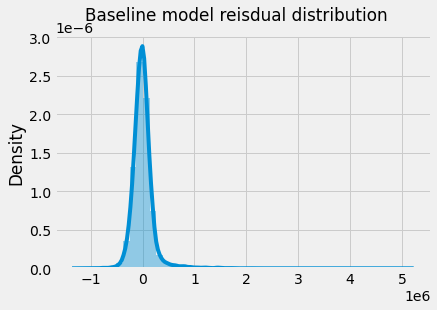

In [132]:
sns.distplot(base_resid)
plt.suptitle("Baseline model reisdual distribution")
plt.show()

In [133]:
base_model_strength = model_strength_indicators(base_model)
base_model_strength

{'r_squared': '0.664',
 'skew': '4.378',
 'kurtosis': '65.320',
 'Durbin Watson': '1.987',
 'Jarque-Bera': '3489038.859',
 'P value': '0.000',
 'Condition': '39367891811523',
 'Coef. weight': 1407743.131565345}

##### Observations:

Data is clearly not normally distributed. First step is to investigate impact of elimating outliers within the target variable based on the statistical maximum (IQR * 1.5)

In [134]:
std_thresh = data.price.std()*3 # three standard deviations 
std_cap = data.loc[abs(data['price']) <= std_thresh] # slicing all data within the defined range

#re-declare X and y variables
y = std_cap.price
X = std_cap[X_base.columns]

Inspect resulting model 

In [135]:
# build model and grab residuals
outlier_model = run_OLS_model(X,y)
outlier_residual = outlier_model.resid

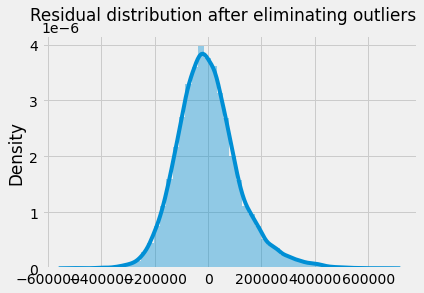

In [136]:
# visualize model residuals
sns.distplot(outlier_residual)
plt.suptitle('Residual distribution after eliminating outliers')
plt.show()

In [137]:
outlier_strength = model_strength_indicators(outlier_model)
outlier_strength

{'r_squared': '0.676',
 'skew': '0.601',
 'kurtosis': '4.321',
 'Durbin Watson': '1.966',
 'Jarque-Bera': '2654.753',
 'P value': '0.000',
 'Condition': '39581359883859',
 'Coef. weight': 850667.3470234225}

Observations: 
- Indicators of normality slightly improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high
- some signs of multi-colinearity

Next step is to investigate the impact of log transforming the target variable

In [138]:
# create log transformed target variable
y_log = np.log(y)

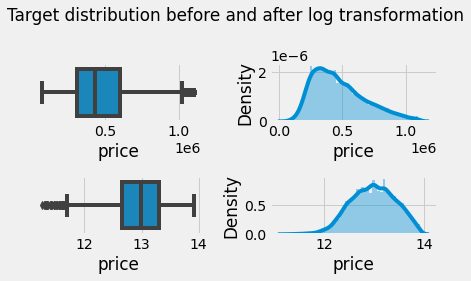

In [139]:
fig,axes = plt.subplots(2,2)

sns.boxplot(y,ax=axes[0,0]) # boxplot before
sns.distplot(y,ax=axes[0,1]) # distplot before

sns.boxplot(y_log,ax=axes[1,0]) # boxplot after
sns.distplot(y_log,ax=axes[1,1]) # boxplot after

fig.suptitle("Target distribution before and after log transformation")
plt.tight_layout()
plt.show()

In [140]:
base_log_model = run_OLS_model(X,y_log)
base_log_residuals = base_log_model.resid

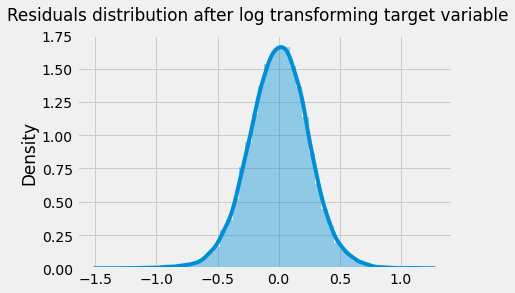

In [141]:
# visualize model residuals
sns.distplot(base_log_residuals)
plt.suptitle('Residuals distribution after log transforming target variable')
plt.show()

In [142]:
base_log_strength = model_strength_indicators(base_log_model)
base_log_strength

{'r_squared': '0.691',
 'skew': '-0.126',
 'kurtosis': '3.739',
 'Durbin Watson': '1.974',
 'Jarque-Bera': '507.404',
 'P value': '0.000',
 'Condition': '39581359883859',
 'Coef. weight': 2.0687928103578277}

Observations: 
- Indicators of normality improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high, but significantly better
- condition number is unchanged

Next step is another round of feature elimination

Continue feature ranking, selection and elimination with log transformed target variable

In [143]:
stepwise_selected = stepwise_selection(X,y_log,verbose=False)
X = X[stepwise_selected]

In [144]:
RFE_selection = run_RFECV(X,y)
X = X[RFE_selection]

In [145]:
good,bad = create_vif_list(X)
X = X[good]

In [146]:
outlier_cor_df = create_CC_df(X,.6,1)
outlier_cor_df

,cc
pairs,
"(sqft_living15, grade)",0.670517
"(bathrooms, grade)",0.614271


In [147]:
log_model = run_OLS_model(X,y_log)
log_residuals = log_model.resid

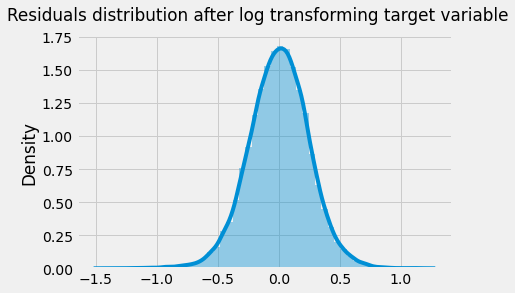

In [148]:
# visualize model residuals
sns.distplot(log_residuals)
plt.suptitle('Residuals distribution after log transforming target variable')
plt.show()

In [149]:
log_model_strength = model_strength_indicators(log_model)
log_model_strength

{'r_squared': '0.691',
 'skew': '-0.127',
 'kurtosis': '3.737',
 'Durbin Watson': '1.974',
 'Jarque-Bera': '506.098',
 'P value': '0.000',
 'Condition': '5412319847',
 'Coef. weight': 2.070136192000776}

Observations: 
- Indicators of normality improved slightly
- skew is still close to zero, kurtosis is still sightly heavy
- r-squared is unchanged
- jarque-bera is fairly high, slightly increased but not enough to worry about. 
- condition number is decreased by three figures which is a major improvement

Next step is to engineer new features from an additional data set and one-hot encode some categorical features.

Observations: After eliminating outliers, log transforming the target variable, and another round of feature selection and elimination. 
- The model continues to improve. 
- Next steps will be to Engineer new features and investigate how they impact the model performance. 

# Engineering new features to further improve the model

- First new features will be engineered by joining IRS data on income by zipcode.
- two categorical variables will be one-hot encoded (waterfront location, and tax bracket)  
- Lastly, new feature may be developed by interpolating existing feature of data. 

Features extrapolated from zipcode

In [150]:
# Dictionary with zipcodes associated with waterfronts described by the data dictionary
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X['waterfront_loc'] = waterfront_list

features interpolated from external data

In [151]:
# IRS income tax data from data.world 
# https://data.world/jonloyens/irs-income-by-zip-code/workspace/query?queryid=0491f7ff-f7e5-49be-ad8c-8047d6a54c57

income = pd.read_csv('data/irs_income_by_zipcode.csv')

income.avg_taxable_income = income.avg_taxable_income*1000 # scaling data back to dollar units (was in thousands)
income.taxable_income_amount = income.taxable_income_amount*1000 
income.rename({'taxable_income_amount':'zip_tax_revenue'},axis=1,inplace=True) # renaming to something more idiomatic

# # create lists to stage data in order to concat new columns later
joint_filing_bracket = [] #for the joint filing tax schedule

# there is probably a more "pythony" way to do this for loop but it works so I'm not touching it 
for average in income.avg_taxable_income:
    if average > 628301:
        joint_filing_bracket.append(7)
    elif average <= 19900:
        joint_filing_bracket.append(1)
    elif (average >= 19901) and (average <= 81050):
        joint_filing_bracket.append(2)
    elif (average >= 81051) and (average <= 172750):
        joint_filing_bracket.append(3)
    elif (average >= 172751) and (average <= 329850):
        joint_filing_bracket.append(4)
    elif (average >= 329851) and (average <= 418850):
        joint_filing_bracket.append(5)
    elif (average >= 418851) and (average <= 628300):
        joint_filing_bracket.append(6)

# assign discovered data to new column
income['joint_filing_tax_bracket'] = joint_filing_bracket

# create dictionary of zipcodes with corresponding tax bracket
# dictionary will be used to assign create similar columns in the principal data.
joint_filing_tax_dict = {}
tax_revenue_dict = {}

# create ditionaries to later assign values to principal data
for row in income.iterrows():
    joint_filing_tax_dict[row[1][0]] = row[1][3]
    tax_revenue_dict[row[1][0]] = row[1][1]

# concat columns to X containing tax bracket based on single and joint filing federal income tax schedule
X['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)


In [152]:
# create dummy variables
waterfront_dummies = pd.get_dummies(X.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
bracket_dummies = pd.get_dummies(X.income_tax_bracket,drop_first=True,prefix='income_tax',prefix_sep='_')
sale_month_dummies = pd.get_dummies(X.sale_month,prefix='sale_month',prefix_sep='_',drop_first=True)

# reasign X to concatenated dataframe, dropping features no longer needed
X = X.drop(['waterfront_loc','zipcode'],axis=1)
X = pd.concat([X,bracket_dummies,waterfront_dummies,sale_month_dummies],axis=1)

### create baseline for engineered features

In [153]:
hot_base = run_OLS_model(X,y_log)
hot_base_residuals = hot_base.resid

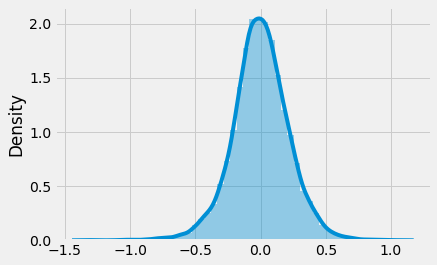

In [154]:
sns.distplot(hot_base_residuals)
plt.show()

In [155]:
hot_base_stregnth = model_strength_indicators(hot_base)
hot_base_stregnth

{'r_squared': '0.761',
 'skew': '-0.138',
 'kurtosis': '4.479',
 'Durbin Watson': '1.980',
 'Jarque-Bera': '1885.080',
 'P value': '0.000',
 'Condition': '11509189577899728',
 'Coef. weight': 150.0737614245788}

Continue to rank, select and eliminate features. 

In [156]:
stepwise_selections = stepwise_selection(X,y_log,verbose=False)
X = X[stepwise_selections]

In [157]:
rfecv_selections = run_RFECV(X,y_log)
X = X[rfecv_selections]

In [158]:
good,bad = create_vif_list(X)
X = X[good[1:]]

In [159]:
hot_model = run_OLS_model(X,y_log)
hot_residuals = hot_model.resid

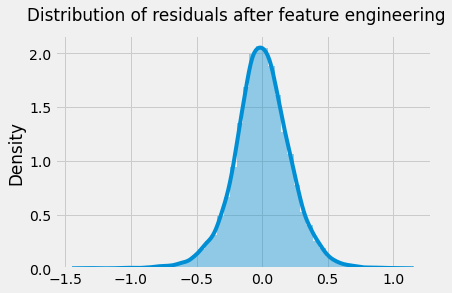

In [160]:
sns.distplot(hot_residuals)
plt.suptitle('Distribution of residuals after feature engineering')
plt.show()

In [161]:
hot_model_strength = model_strength_indicators(hot_model)
hot_model_strength

{'r_squared': '0.761',
 'skew': '-0.137',
 'kurtosis': '4.466',
 'Durbin Watson': '1.979',
 'Jarque-Bera': '1851.823',
 'P value': '0.000',
 'Condition': '16617636091687',
 'Coef. weight': 1.7687236929070773}

Continue eliminating features manually to address remaining multi-colinearity and further fit the model 

In [162]:
correlations = create_CC_df(X,minimum=0.5)
correlations

,cc
pairs,
"(sqft_living15, grade)",0.670517
"(grade, bathrooms)",0.614271
"(income_tax_bracket, zip_tax_revenue)",0.591402
"(bathrooms, yr_built)",0.546328
"(bathrooms, sqft_living15)",0.528819
"(sale_date, sale_month_4)",0.506477


In [163]:
vif_dict = create_vif_dictionary(X)
vif_dict

{'const': 0.0,
 'bathrooms': 2.3444606263848207,
 'lat': 1.477476555621861,
 'zip_tax_revenue': 1.8081220862815088,
 'view': 1.1909322036039092,
 'sqft_living15': 2.2693139273611767,
 'income_tax_bracket': 1.8350104374984169,
 'grade': 2.4819685993326757,
 'yr_built': 2.2983795423870594,
 'waterfront_Lake Washington': 1.1512938407756592,
 'condition': 1.2151579374351715,
 'sale_date': 4.068796731272385,
 'sqft_lot15': 1.1231404643550829,
 'waterfront_Duwamish': 1.0344924183713202,
 'waterfront': 1.0907896081556643,
 'long': 1.5037107582396239,
 'bedrooms': 1.412958200786228,
 'yr_renovated': 1.1042177012063525,
 'sale_month_4': 1.7298672859951383,
 'waterfront_Lake Union': 1.0158410597933178,
 'waterfront_Elliott Bay': 1.058280364076157,
 'sale_month_12': 1.522520624582208,
 'sale_month_6': 2.0324634393497867,
 'sale_month_5': 1.7212155591206493,
 'sale_month_7': 1.6504703283178102,
 'sale_month_8': 1.3520662577496323,
 'sale_month_3': 1.5576488120379615,
 'sale_month': 2.3189644629609

In [164]:
# manually eliminating features based on VIF, and colinearity coefficient
# X_test is used here in lieu of X so that different features can be mixed and matched without re-running the entire notebook everytime.

low_vifs = [k for k,v in vif_dict.items() if v < 2.5][1:]
X_test = X[low_vifs]

# feature_ranks = hot_model.summary2().tables[1]['Coef.'].sort_values(ascending=False)
# positive_features = list(feature_ranks.loc[feature_ranks > 0].keys())
# X_test = X[positive_features]

In [165]:
vif_dict = create_vif_dictionary(X_test)
# vif_dict

In [166]:
new_model = run_OLS_model(X_test,y_log)
new_residuals = new_model.resid

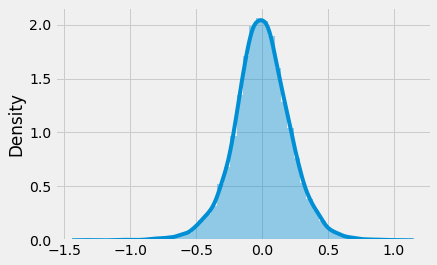

In [167]:
sns.distplot(new_residuals)
plt.show()

In [168]:
new_model_strength = model_strength_indicators(new_model)
new_model_strength

{'r_squared': '0.759',
 'skew': '-0.135',
 'kurtosis': '4.470',
 'Durbin Watson': '1.980',
 'Jarque-Bera': '1858.428',
 'P value': '0.000',
 'Condition': '1423364603841',
 'Coef. weight': 1.6933762793915226}

# Review model performance across iterations
Features are ranked, selected and eliminated through each iteration using the same selection pattern: first selection and elimination based on p-value using a forward-backward stepwise selection method, second selction and elimination based on feature "importance" using recursive feature elimination with cross validation. third selection and elimination based on multi-colinearity determined first by variance inflation factor and second using colinearity coefficients.

- base_model_strength: all original data features, all numerical datatypes, no NaN values
- outlier_strength: records where the target variable (price) is more than three standard deviations away from the target mean. 
- log_model_strength: target variable has been log transformed (regression coefficients now represent change in percentage, not original units of feature).
- hot_model_strength: New features engineered from original data set and and auxilary data set, two categorical variables are one-hot-encoded.
- new_model_strength: Some features are eliminated manually to achieve better normality. 

Baseline model strength after firs round of feature selection and elimination

In [169]:
strength_list = [base_model_strength,outlier_strength,base_log_strength,log_model_strength,hot_model_strength,new_model_strength]
data_dict = {
'r_squares':[float(strength['r_squared']) for strength in strength_list],
'skews':[float(strength['skew']) for strength in strength_list],
'kurtoses':[float(strength['kurtosis']) for strength in strength_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in strength_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in strength_list],
'P values':[float(strength['P value']) for strength in strength_list],
'Condition numbers':[int(strength['Condition']) for strength in strength_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in strength_list]
}

legend_strings = list(data_dict.keys())
tick_label_list = ['base_model','outlier_model','base_log','log_model','hot_model','new_model']

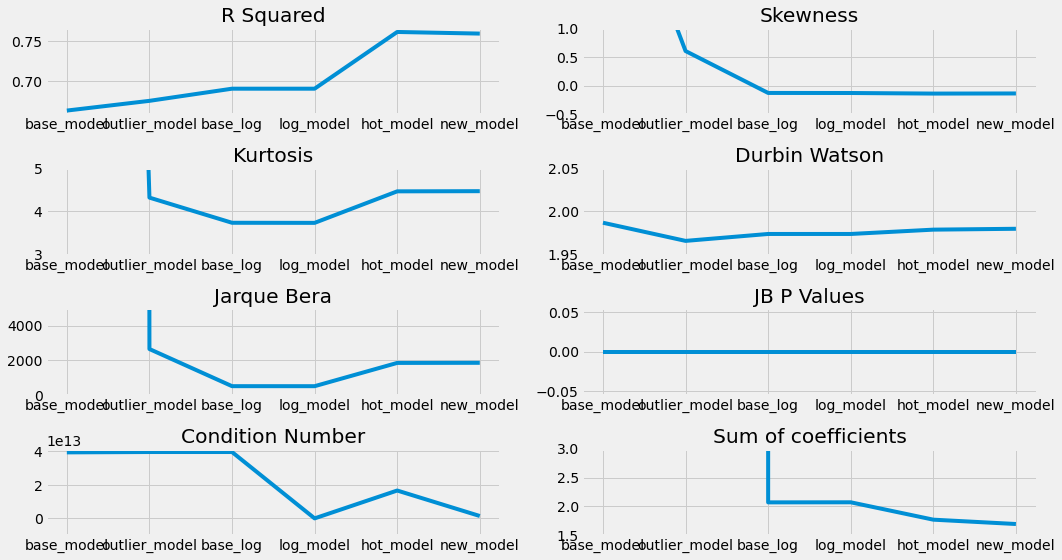

In [170]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=tick_label_list,y=data_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=tick_label_list,y=data_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=tick_label_list,y=data_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=tick_label_list,y=data_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=tick_label_list,y=data_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=tick_label_list,y=data_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=tick_label_list,y=data_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=tick_label_list,y=data_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
plt.show()

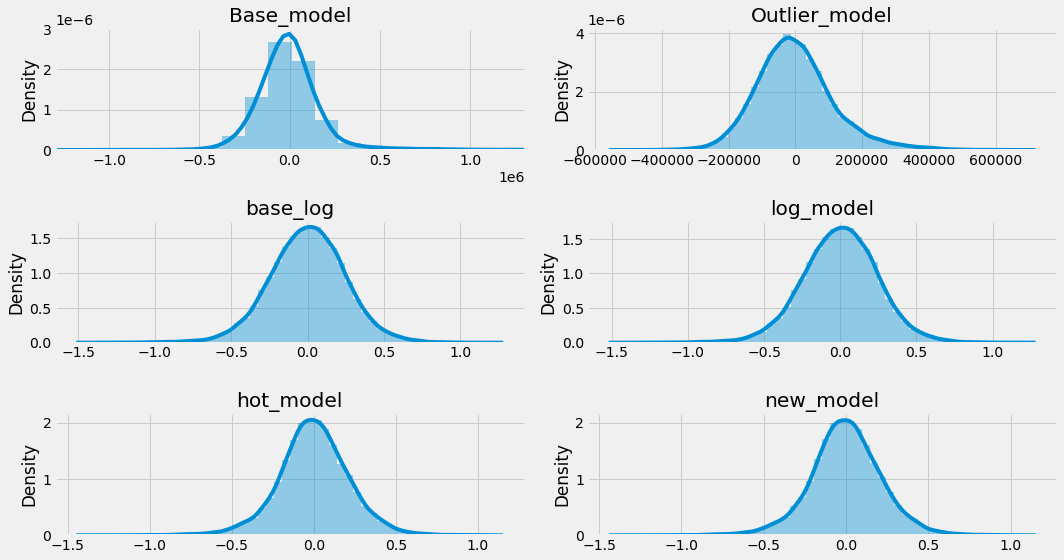

In [171]:
fig, axes = plt.subplots(3,2)

bs = sns.distplot(base_resid,ax=axes[0,0]).set_title('Base_model')
axes[0,0].set_xlim(-1300000,1300000)
ot = sns.distplot(outlier_residual,ax=axes[0,1]).set_title('Outlier_model')
bl = sns.distplot(base_log_residuals,ax=axes[1,0]).set_title('base_log')
lm = sns.distplot(log_residuals,ax=axes[1,1]).set_title('log_model')
hm = sns.distplot(hot_residuals,ax=axes[2,0]).set_title('hot_model')
nm = sns.distplot(new_residuals,ax=axes[2,1]).set_title('new_model')

plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
plt.show()

Due to the size of the data set, in this instance the Q-Q plot is not a very useful tool for determining how well the model satisfies the assumption of normality, however the figure below does clearly show how the log transformation on the target variable significantly improved the model at the begining of the iterative process

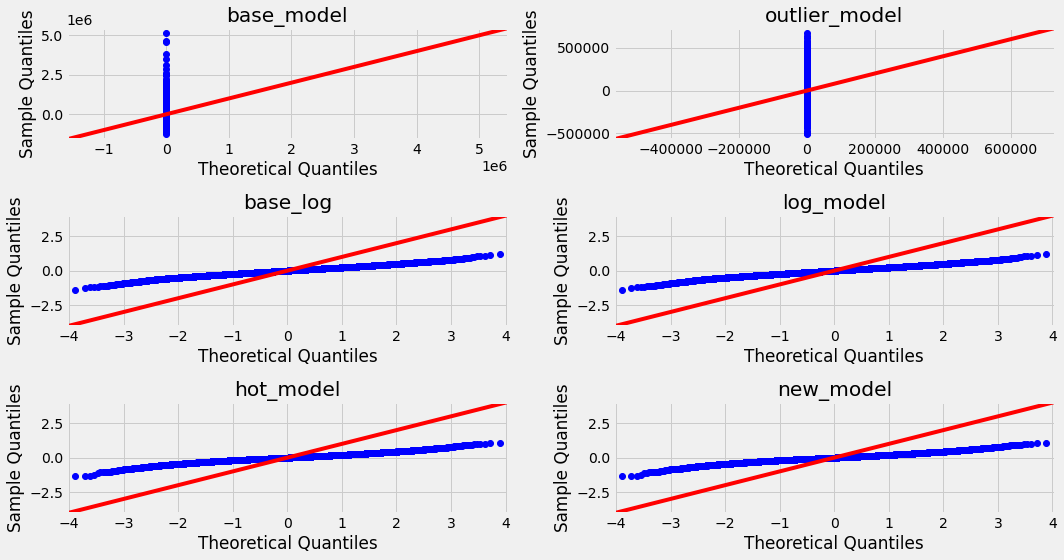

In [172]:
fig, axes = plt.subplots(3,2)

sm.qqplot(base_resid,line='45',ax=axes[0,0])
axes[0,0].set_title('base_model')
sm.qqplot(outlier_residual,line='45',ax=axes[0,1])
axes[0,1].set_title('outlier_model')
sm.qqplot(base_log_residuals,line='45',ax=axes[1,0])
axes[1,0].set_title('base_log')
sm.qqplot(log_residuals,line='45',ax=axes[1,1])
axes[1,1].set_title('log_model')
sm.qqplot(hot_residuals,line='45',ax=axes[2,0])
axes[2,0].set_title('hot_model')
sm.qqplot(new_residuals,line='45',ax=axes[2,1])
axes[2,1].set_title('new_model')

plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
plt.show()

# Model validation

In [173]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

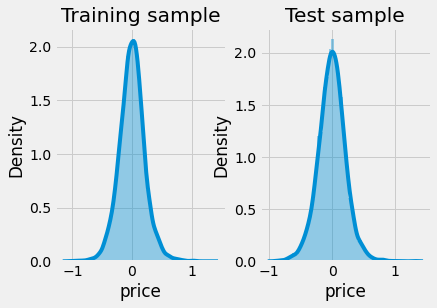

<Figure size 1440x1440 with 0 Axes>

In [174]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

plt.figure(figsize=(20,20))
plt.show()


In [175]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.047
Test Mean Squarred Error: 0.047
Difference:  0.0


In [176]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))


Five k-fold MSE:  -0.048
Ten k-fold MSE:  -0.048
Twenty k-fold MSE:  -0.047


#### observations on model validation
The mean squared error (MSE), a statistic representing the amount of error in a the model (i.e. how well the regression line fits the data), is calculated to be roughly the same using both a simple train-test split and the k-fold cross validation technique. The MSE is close to zero indicating the model fits the data well, and the model probably fits the real population data also. 

# Final observations

In [ ]:
new_model.summary()